In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", rc={"figure.figsize": (10, 10)})

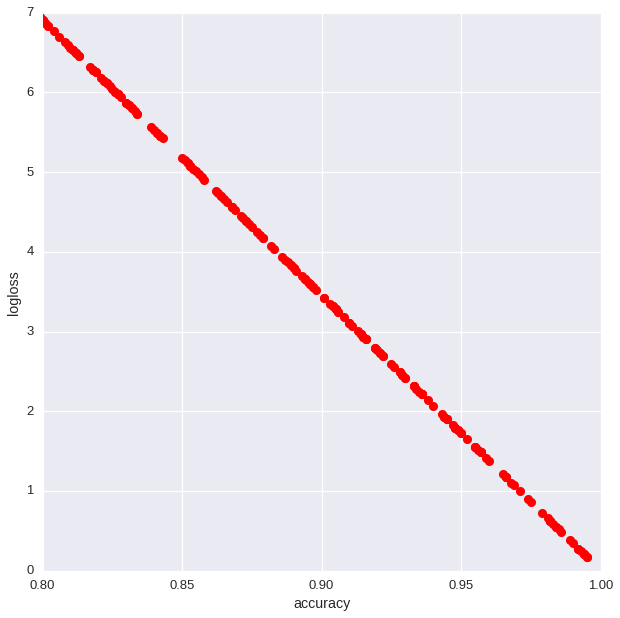

In [4]:
# просто график зависимости logloss от accuracy на наборах случайных данных
# не имеет отношения к тому, что выше или ниже

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

larray, aarray = [], []
ASIZE = 1000

for i in range(1000):
    #y = np.random.randint(0, 2, (ASIZE))
    #out = np.random.randint(0, 2, (ASIZE))
    
    k = np.random.randint(0, ASIZE)
    y = np.zeros((ASIZE))
    out = np.append(np.zeros(k), np.ones(ASIZE-k))
    
    ll = log_loss(y, out, labels = (0, 1))
    accuracy = np.mean(np.equal(y, out).astype(int))
    
    larray.append(ll)
    aarray.append(accuracy)

plt.plot(aarray, larray, 'ro')
plt.axis([0.8, 1, 0, 7])
plt.xlabel('accuracy')
plt.ylabel('logloss')
#plt.show()

In [5]:
# для себя, чтобы не забывать

all_params = ["maxPlayerLevel",
              "numberOfAttemptedLevels",
              "attemptsOnTheHighestLevel",
              "totalNumOfAttempts",
              "averageNumOfTurnsPerCompletedLevel",
              "doReturnOnLowerLevels",
              "numberOfBoostersUsed",
              "fractionOfUsefullBoosters",
              "totalScore",
              "totalBonusScore",
              "totalStarsCount",
              "numberOfDaysActuallyPlayed",
]

In [6]:
# оригинальный трейнсет
x_train_original = pd.read_csv("data/x_train.csv", delimiter=";", dtype=np.float32)

# оригинальные ответы к трейнсету
y_train_original = pd.read_csv("data/y_train.csv", delimiter=";", header=None,
                      names=["returned"], dtype=np.float32)

# оригинальный тестсет
x_test_original = pd.read_csv("data/x_test.csv", delimiter=";", dtype=np.float32)

# датафрейм из оригинального трейнсета с ответами в колонке returned
x_y_train_original = pd.concat([x_train_original, y_train_original], axis=1)

# датафрейм из оригинальных трейнсетов и тестсетов без ответов
x_train_test_original = pd.concat([x_train_original, x_test_original], axis=0, ignore_index=True)

# датафрейм из оригинальных трейнсетов и тестсетов с ответами для трейна и NaN для теста
x_y_train_test_original = pd.concat([x_train_test_original, y_train_original], axis=1)

# далее мы будем работать с одной таблицей со всеми мать ее данными x_y_train_test_original
# и искренне надеяться что правильно ее сгенерили
# переназовем ее xytt

xytt = x_y_train_test_original

# а также заведем таблицу, куда будем дописывать наши идиотские новые колонки, xytt Extended

xytte = xytt.copy()

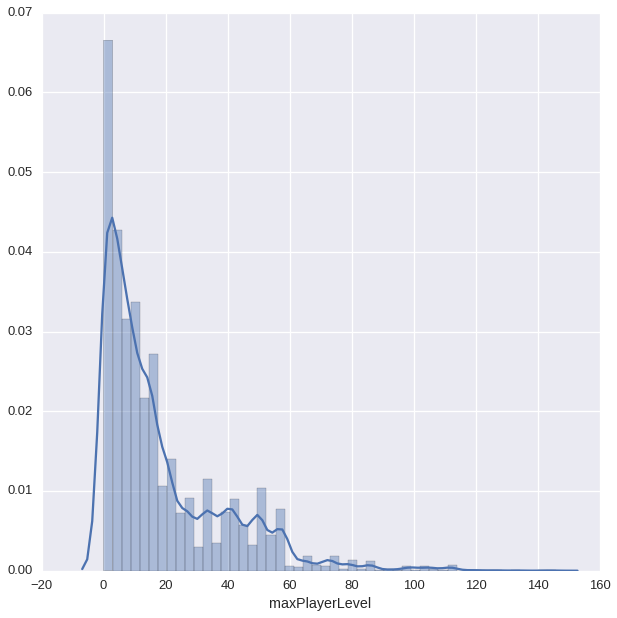

In [7]:
# сам по себе макслевел выглядит хуевенько

_ = xytte["maxPlayerLevel"]
s = sns.distplot(_)
#_.describe()

In [8]:
# поэтому слогарифмируем и отнормализуем его
xytte["maxPlayerLevel_ln"] = xytte["maxPlayerLevel"].apply(lambda x: np.log(x+1))
s = sns.distplot(norm(xytte["maxPlayerLevel_ln"]))
# лукс чуть пижже

NameError: name 'norm' is not defined

In [ ]:
# второй параметр - numberOfAttemptedLevels
# выглядит он тоже не очень

sns.distplot(xytte["numberOfAttemptedLevels"])

In [ ]:
# проверим, зависит ли он как-то от первого

sns.jointplot(x="maxPlayerLevel", y="numberOfAttemptedLevels", data=xytte)

In [ ]:
# оказывается, да
# может, поделить его на макслевел?

xytte["numberOfAttemptedLevels_dvd"] = (xytte["numberOfAttemptedLevels"]) / (xytte["maxPlayerLevel"] + 1)
#numberOfAttemptedLevels_dvd.columns = ["numberOfAttemptedLevels_dvd"]
sns.jointplot(x="maxPlayerLevel", y="numberOfAttemptedLevels_dvd", data=xytte)
#s = sns.distplot(norm(numberOfAttemptedLevels_dvd))
#numberOfAttemptedLevels_dvd
#xytt

In [ ]:
# первая группа людей - у которых количество попыток больше, чем максимальный уровень, причем ровно на один
# их 38 тысяч, и на них очевидно нужен какой-нибудь булевый столбец
# проверим, убрав из графика людей с нулевым макслевелом
# очень хочется их считать отдельно, посмотрим, как пойдет

cut = xytte[xytte["maxPlayerLevel"] > xytte["numberOfAttemptedLevels"]]
s = sns.lmplot(x="maxPlayerLevel", y="numberOfAttemptedLevels_dvd", 
           data=cut, hue="returned", fit_reg=True, scatter_kws={"s": 10}, size=5)
#s.show()
cut.count()
#_ = (cut3 - 1) * 2**(xytt["numberOfAttemptedLevels"]/50) + 1
#sns.jointplot(x=xytt["numberOfAttemptedLevels"], y=_)

In [ ]:
# ебанем буля
xytte["attLevelsMoreThanMaxLevel"] = (xytte["numberOfAttemptedLevels"] > xytte["maxPlayerLevel"]) * 1.0
#xytte["attLevelsLessThanMaxLevel"] = (xytte["numberOfAttemptedLevels"] <= xytte["maxPlayerLevel"]) * 1.0

In [ ]:
# едем дальше - attemptsOnTheHighestLevel

sns.distplot(xytte["attemptsOnTheHighestLevel"])
xytte["attemptsOnTheHighestLevel"].describe()

In [ ]:
# ну понятно, все пробуют по одному разу, 75% не больше трех, а один еблан пробовал аж 365
# по этому распределению снова плачет логарифм

xytte["attemptsOnTheHighestLevel_ln"] = np.log(xytte["attemptsOnTheHighestLevel"])
sns.distplot(xytte["attemptsOnTheHighestLevel_ln"])

In [ ]:
# кроме того, интересно посмотреть корреляцию с прошлыми столбцами
xytte[["attemptsOnTheHighestLevel_ln", "numberOfAttemptedLevels_dvd", "maxPlayerLevel_ln"]].corr()

In [ ]:
# есть с максуровнем, надо построить гистограммку и посмотреть, что почем

#sns.lmplot(x="maxPlayerLevel", y="attemptsOnTheHighestLevel", data=xytte, hue="returned", fit_reg=False, scatter_kws={"s": 10})
g = sns.FacetGrid(xytte, col="returned")
g.map(plt.scatter, "maxPlayerLevel", "attemptsOnTheHighestLevel", alpha=.7)
g.add_legend();

In [ ]:
# нихуя не вижу

sns.lmplot(x="maxPlayerLevel", y="attemptsOnTheHighestLevel", data=xytte, hue="returned", fit_reg=True)

In [ ]:
# и даже фитовочные линии для вернувшихся и нет одни и те же
# в пизду, нормируем и дальше идем
# можно попробовать ввести столбец на "пробовал не больше трех раз", но хз, потом попробую

In [ ]:
# теперь totalNumOfAttempts

sns.distplot(xytte["totalNumOfAttempts"])
xytte["totalNumOfAttempts"].describe()

In [ ]:
# те же яйца
# логарифм и корреляции

xytte["totalNumOfAttempts_ln"] = np.log(xytte["totalNumOfAttempts"])
sns.distplot(xytte["totalNumOfAttempts_ln"])
xytte[["attemptsOnTheHighestLevel_ln", "numberOfAttemptedLevels_dvd", "maxPlayerLevel_ln", "totalNumOfAttempts_ln"]].corr()

In [ ]:
# 0.6 и 0.8, охуеть
# но логарифм хорошо отработал

sns.lmplot(x="maxPlayerLevel", y="totalNumOfAttempts_ln", 
           data=xytte, hue="returned", fit_reg=True, scatter_kws={"s": 10})

In [ ]:
# а что если визуализировать все четыре штуки пока

sns.pairplot(xytte, vars=["maxPlayerLevel_ln",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_ln",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

In [ ]:
# найс
# кстати, число попыток на хайест левеле надо бы поделить на общее число попыток
# получим график поровнее и процент попыток на маклевеле

# вообще мне пришла в голову идея, что надо избавляться от корреляций
# это в некотором смысле ортогонализация входных данных, результат от этого должен только выиграть
# но это буду делать массово потом, наверное

xytte["attemptsOnTheHighestLevel_dvd"] = (xytte["attemptsOnTheHighestLevel"]) / (xytte["totalNumOfAttempts"] + 0)

sns.pairplot(xytte, vars=["attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

In [ ]:
# выглядит поинтереснее
# добавим булев столбец для чуваков со ста процентами, больно их много
# а логарифмировать не будем, и так сойдет

xytte["allAttemptsOnTheHighestLevel"] = (xytte["attemptsOnTheHighestLevel"] == xytte["totalNumOfAttempts"]) * 1.0

In [ ]:
# averageNumOfTurnsPerCompletedLevel - показатель тупизны

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel",
                          "maxPlayerLevel"], hue="returned", size=5)

In [ ]:
# во-первых, чуваки с нулем отправляются в булев ад
# их 1266
xytte["zeroTurnsPerCompletedLevel"] = (xytte["averageNumOfTurnsPerCompletedLevel"] == 0) * 1.0

# во-вторых, наблюдается какая-то корреляция с макслевелом
xytte[["averageNumOfTurnsPerCompletedLevel", "maxPlayerLevel"]].corr()

In [ ]:
# возможно, стоит поделить одно на другое

xytte["averageNumOfTurnsPerCompletedLevel_dvd"] = (xytte["averageNumOfTurnsPerCompletedLevel"] \
                                                - (xytte["maxPlayerLevel"] + 1) / 9) \
                                                * (1 - xytte["zeroTurnsPerCompletedLevel"])
#for i, v in enumerate(cut["zeroTurnsPerCompletedLevel"]):
#    if not v:
#        cut["averageNumOfTurnsPerCompletedLevel_div"][i] = 0 
sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "maxPlayerLevel"], hue="returned", size=5)
xytte[["averageNumOfTurnsPerCompletedLevel_dvd", "maxPlayerLevel"]].corr()


In [ ]:
# вроде симпатичнее
# посмотрим на остальные плоты

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

In [ ]:
""" 
нормуль
итого из пяти колонок

'maxPlayerLevel',
'numberOfAttemptedLevels',
'attemptsOnTheHighestLevel',
'totalNumOfAttempts',
'averageNumOfTurnsPerCompletedLevel'

получилось еще 11

'maxPlayerLevel_ln',
'numberOfAttemptedLevels_dvd',
'attLevelsMoreThanMaxLevel',
'attLevelsLessThanMaxLevel',
'attemptsOnTheHighestLevel_ln',
'totalNumOfAttempts_ln',
'attemptsOnTheHighestLevel_div',
'allAttemptsOnTheHighestLevel',
'zeroTurnsPerCompletedLevel',
'attemptsOnTheHighestLevel_dvd',
'averageNumOfTurnsPerCompletedLevel_dvd'

отлично, работаем дальше """

In [ ]:
# следующая колонка - doReturnOnLowerLevels
# сама по себе булева, хуй с ней че сделаешь
# можно посмотреть на раскрасочки

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], 
             hue="doReturnOnLowerLevels", size=5)

In [ ]:
# и даже особо ни с кем не коррелирует
# и хуй с ней
# numberOfBoostersUsed

sns.pairplot(xytte, vars=["numberOfBoostersUsed",
                          "maxPlayerLevel"], hue="returned", size=5)

In [2]:
sns.distplot(xytte["numberOfBoostersUsed"], bins=86)

NameError: name 'sns' is not defined

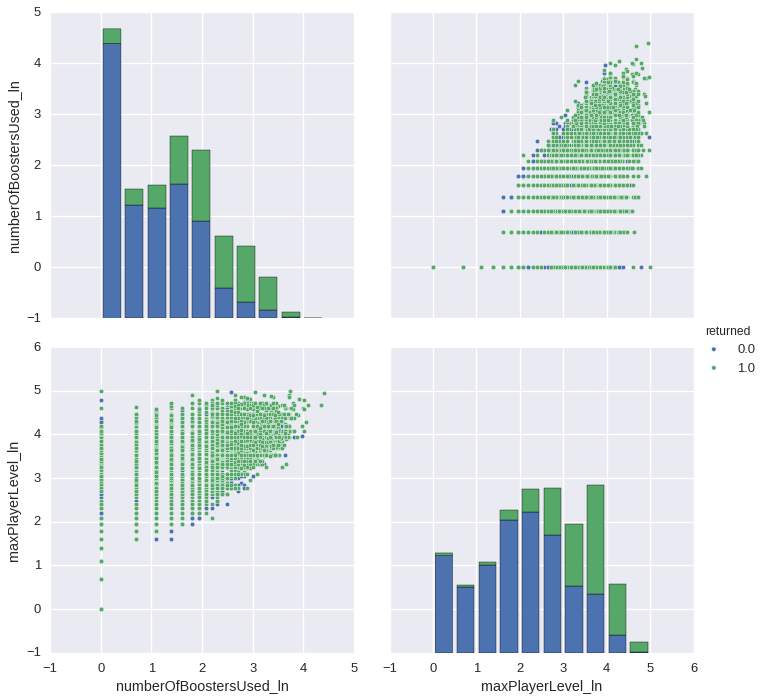

In [121]:
# по бустерам плачет логарифм

xytte["numberOfBoostersUsed_ln"] = xytte["numberOfBoostersUsed"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["numberOfBoostersUsed_ln",
                          "maxPlayerLevel_ln"], hue="returned", size=5)

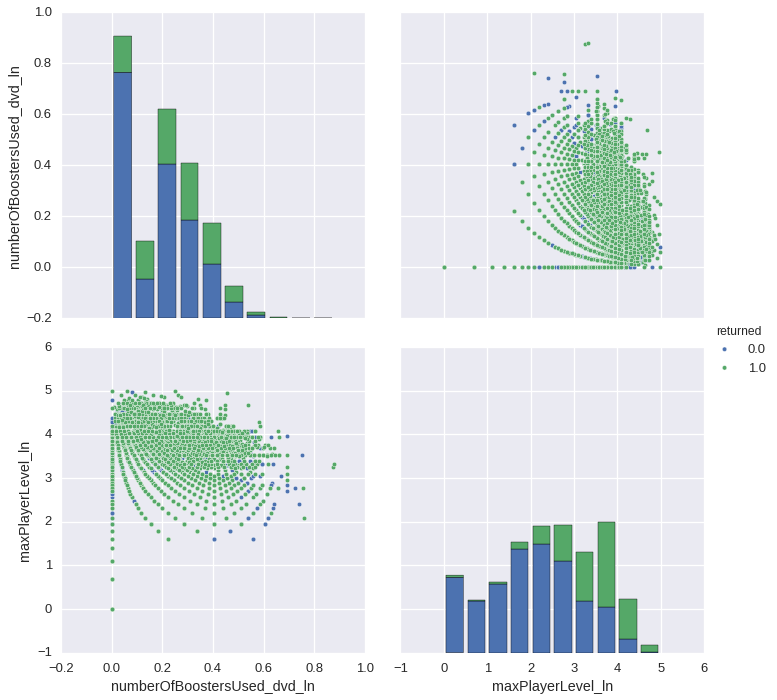

In [122]:
# стало получше
# тем не менее, можно заметить, что график черезчур линеен, кол-во бустеров почти всегда меньше левела
# поделим и посмотрим

xytte["numberOfBoostersUsed_dvd"] = xytte["numberOfBoostersUsed"] / (xytte["maxPlayerLevel"] + 0.01)
xytte["numberOfBoostersUsed_dvd_ln"] = xytte["numberOfBoostersUsed_dvd"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["numberOfBoostersUsed_dvd_ln",
                          "maxPlayerLevel_ln"], hue="returned", size=5)

1.4068863

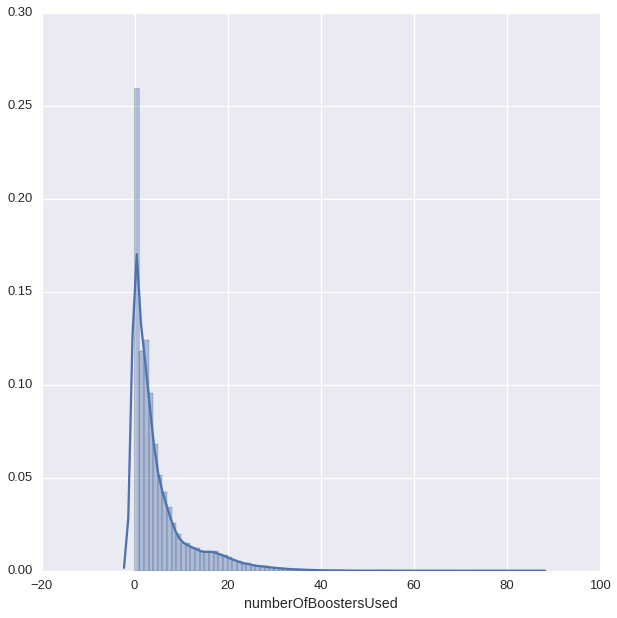

In [123]:
# не уверен, что нужен буль для чуваков без бустера
# не вижу ступеньки
sns.distplot(xytte["numberOfBoostersUsed"], bins=86)
xytte["numberOfBoostersUsed_dvd"].max()

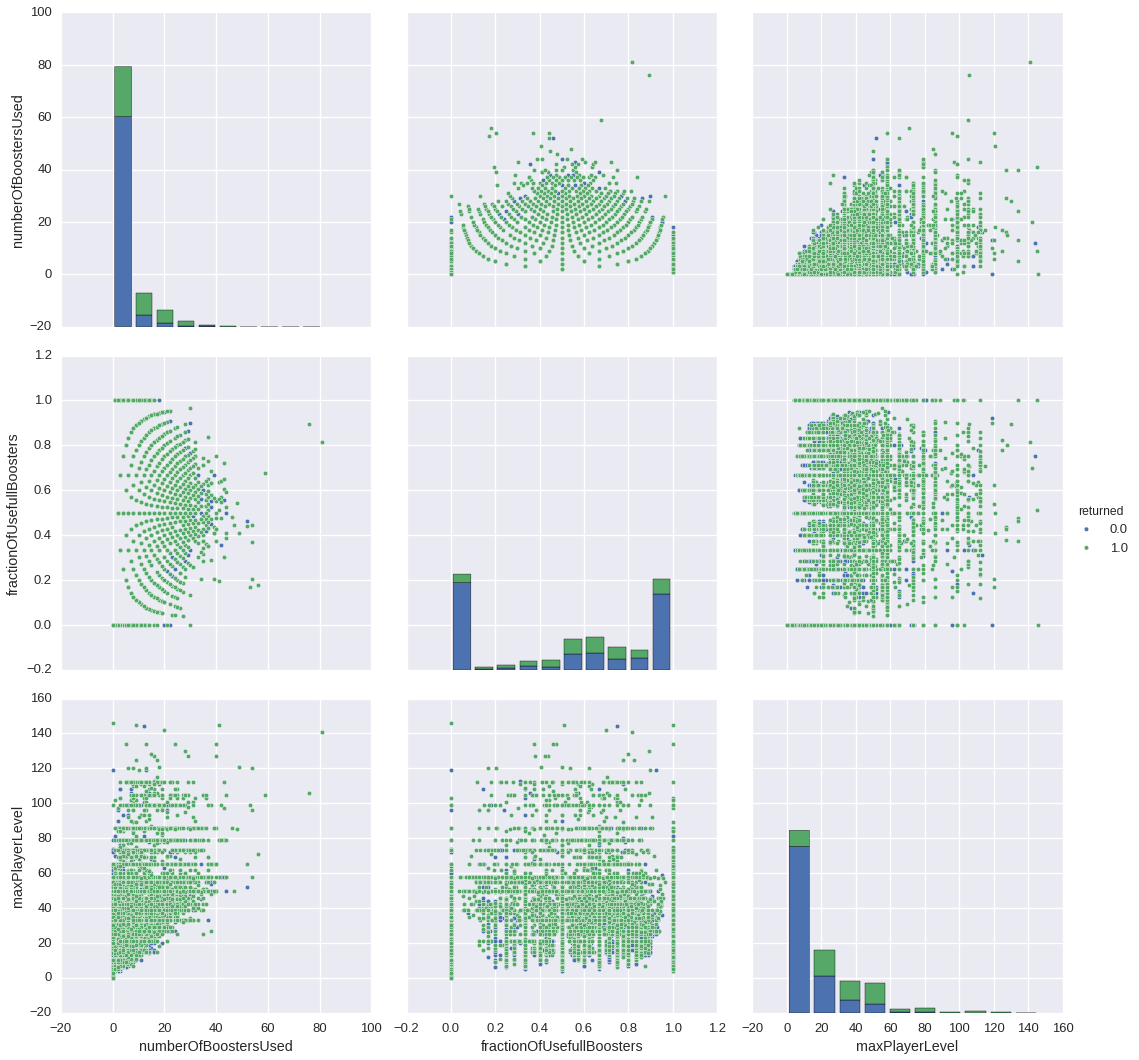

In [124]:
# fractionOfUsefullBoosters

sns.pairplot(xytte, vars=["numberOfBoostersUsed",
                          "fractionOfUsefullBoosters",
                          "maxPlayerLevel"], hue="returned", size=5)

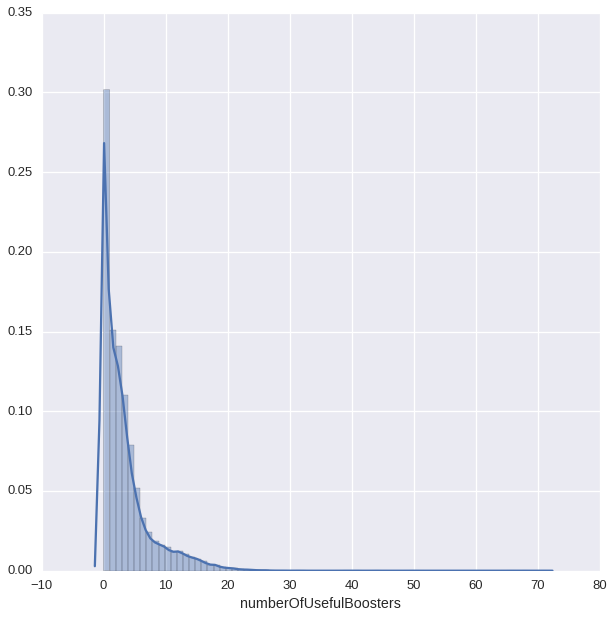

In [15]:
xytte["numberOfUsefulBoosters"] = xytte["fractionOfUsefullBoosters"] * xytte["numberOfBoostersUsed"]
#sns.pairplot(xytte, vars=["totalScore", "maxPlayerLevel"], hue="doReturnOnLowerLevels", size=5)
sns.distplot(xytte["numberOfUsefulBoosters"], bins=72)
#xytte["numberOfUsefulBoosters"].describe()

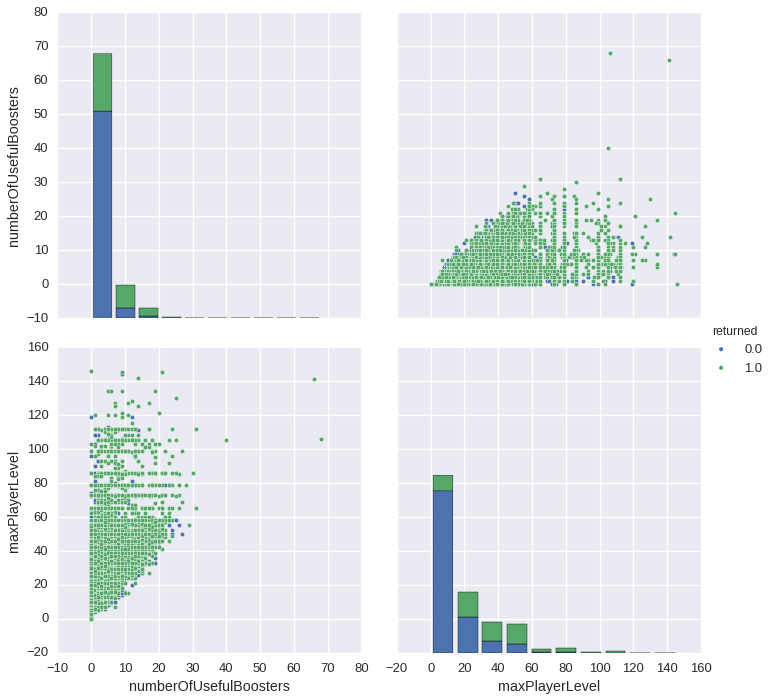

In [11]:
# меня устраивает
# totalScore
# окраска в вернувшихся на нижние уровни, должно быть более релевантно
sns.pairplot(xytte, vars=["numberOfUsefulBoosters", "maxPlayerLevel"], hue="returned", size=5)

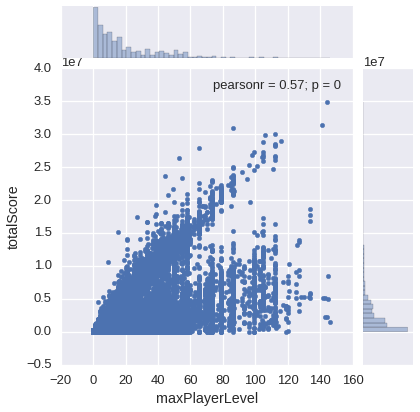

In [126]:
# и к вопросу о том, зачем нужны логарифмы
# на графике кажется, что половина точек накидана плеерлевеле от 1 до 60
# а реально от 1 до 10
sns.jointplot(x="maxPlayerLevel", y="totalScore", data=xytte)


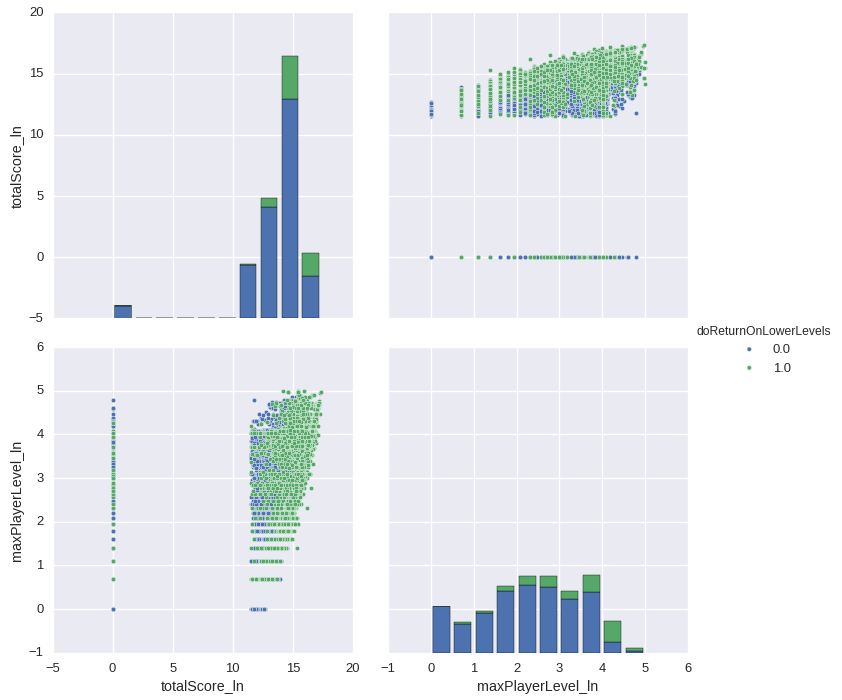

In [127]:
xytte["totalScore_ln"] = xytte["totalScore"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["totalScore_ln", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)

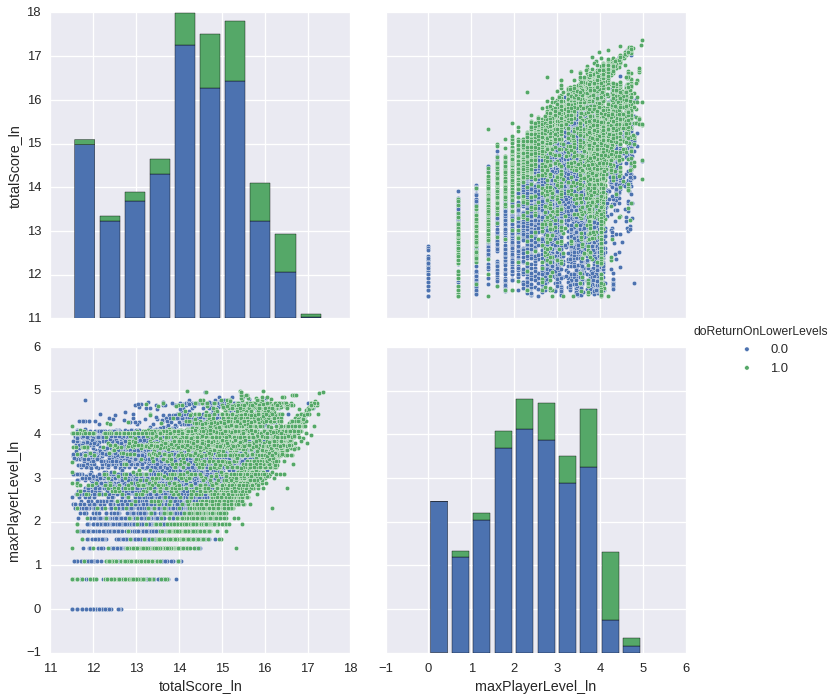

In [128]:
# уродливо выглядят чуваки с нулевым тоталскором, обрежем их
cut = xytte[xytte["totalScore_ln"] > 0]

sns.pairplot(cut, vars=["totalScore_ln", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


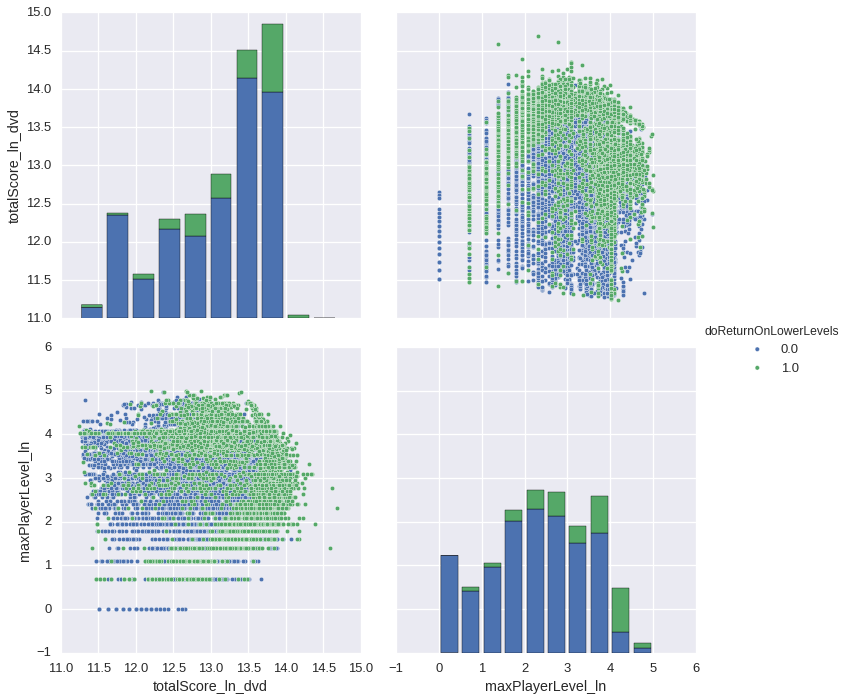

In [129]:
# попробуем отнять макслевел для более ровной картинки

cut["totalScore_ln_dvd"] = cut["totalScore_ln"] - (cut["totalScore_ln"] - 11) * cut["maxPlayerLevel_ln"] / 8
sns.pairplot(cut, vars=["totalScore_ln_dvd", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)


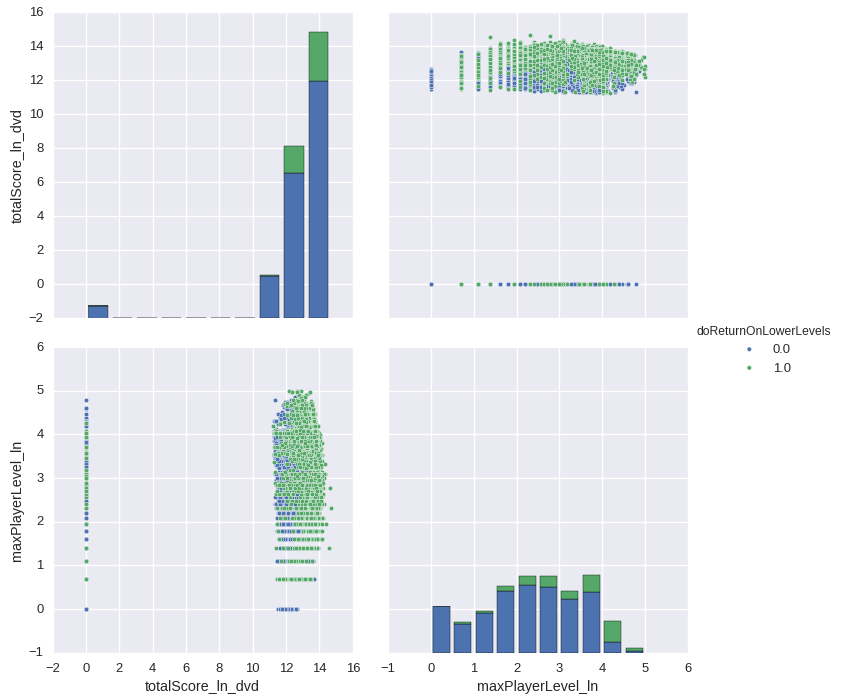

In [130]:
# осталась проблема с выколотыми значениями

xytte["totalScore_ln_dvd"] = (xytte["totalScore_ln"] > 0) * \
                             (xytte["totalScore_ln"] - \
                             (xytte["totalScore_ln"] - 11) * xytte["maxPlayerLevel_ln"] / 8)
sns.pairplot(xytte, vars=["totalScore_ln_dvd", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)

In [131]:
# чует мое сердце, надо их будет либо отдельной таблицей прогонять, либо булеву переменную херачить
# их не так много, 1200, но все же
# причем где-то три к одному вернувшихся к покинувшим, то есть вообще не факт, что ноль что-то значит
# но давайте введем

xytte["zeroTotalScore"] = (xytte["totalScore"] == 0) * 1.0

len(xytte[(xytte.totalScore == 0) & (xytte.returned == 1)].index) / \
len(xytte[(xytte.totalScore == 0) & (xytte.returned == 0)].index)

0.2778904665314402

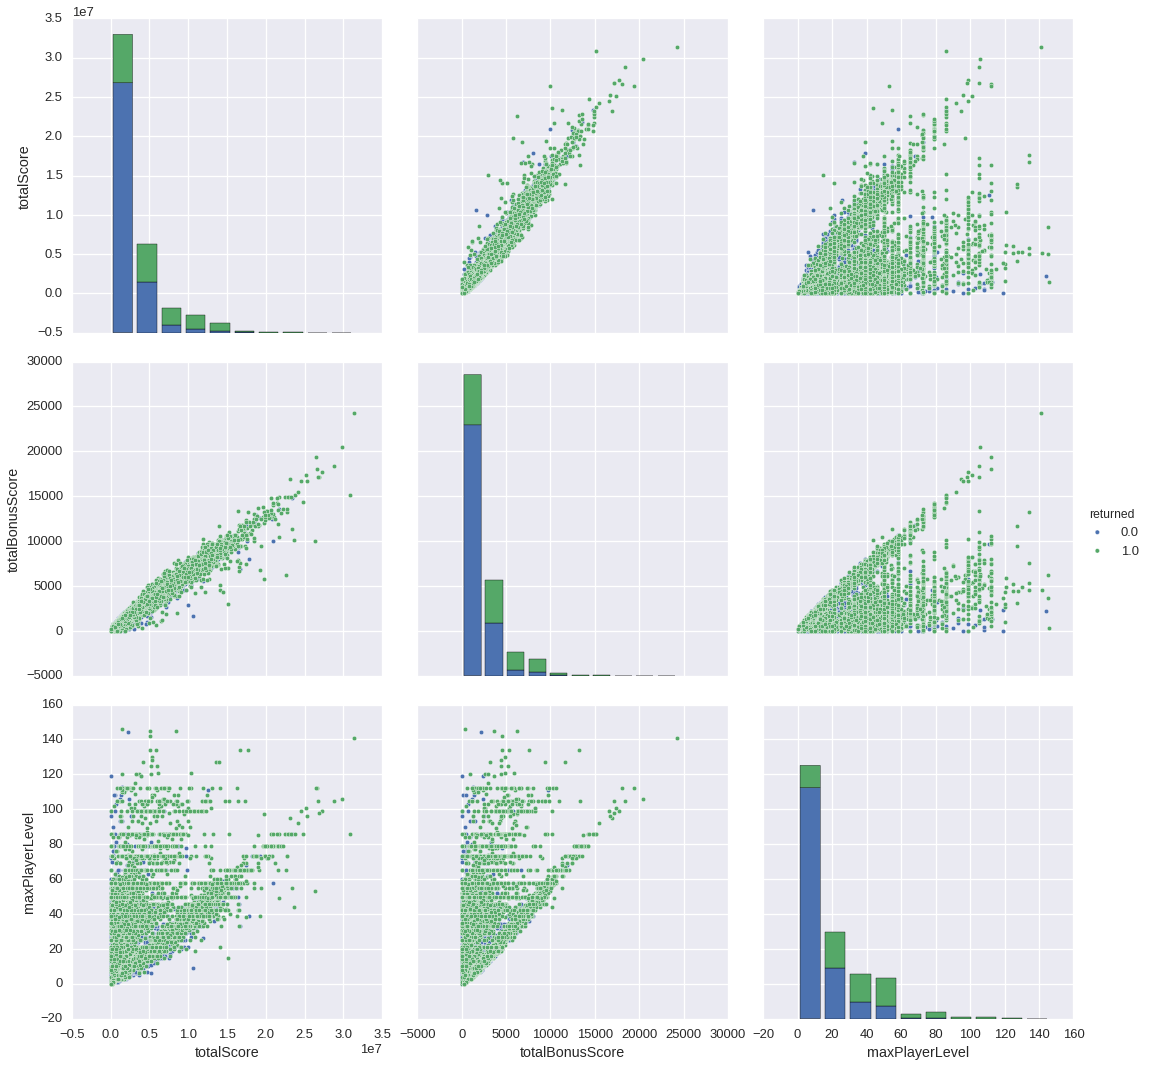

In [132]:
# totalBonusScore

sns.pairplot(xytte, vars=["totalScore", "totalBonusScore", "maxPlayerLevel"], 
             hue="returned", size=5)

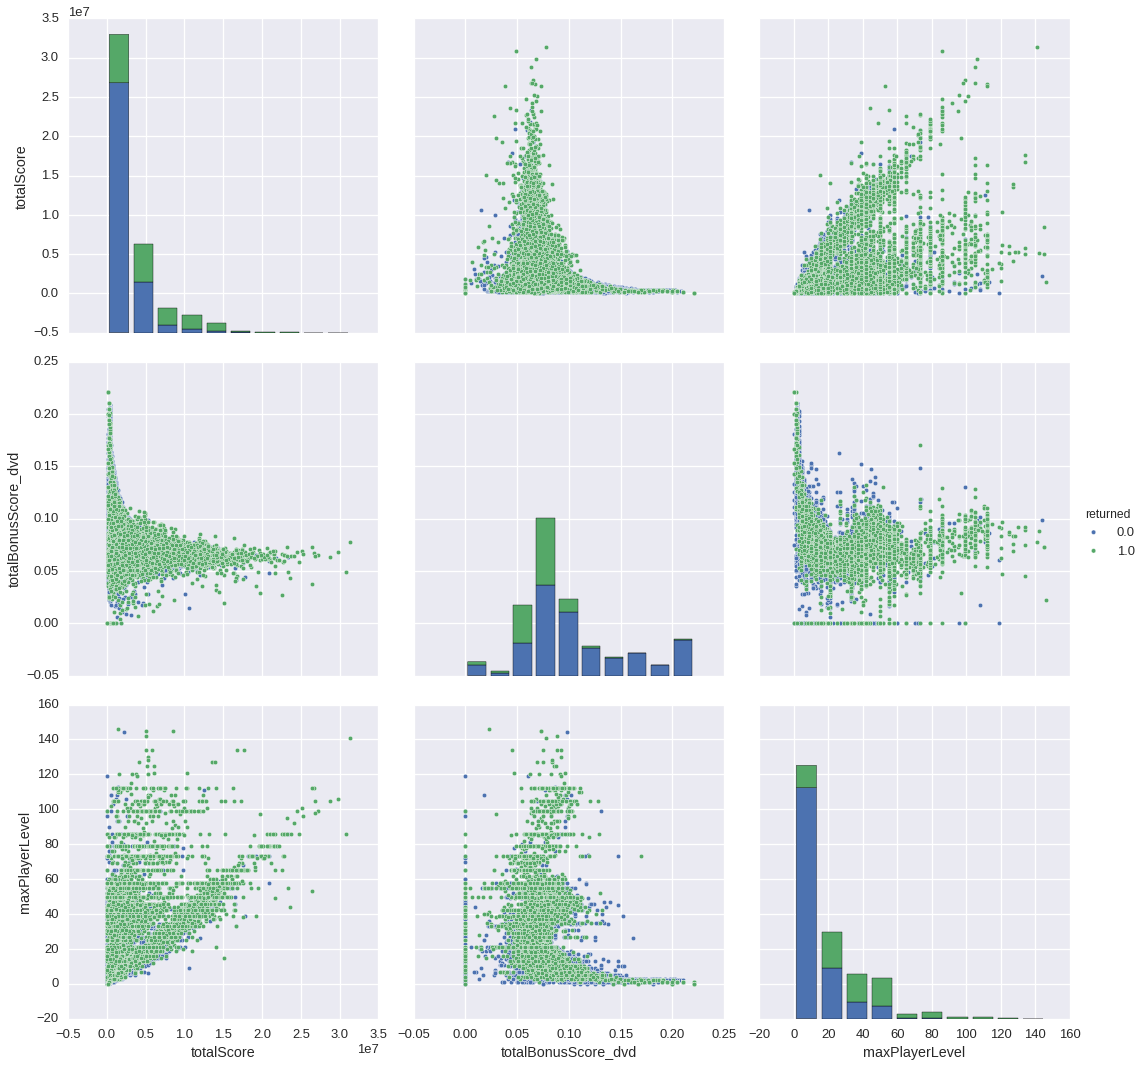

In [133]:
# даже непонятно, делить или логарифмировать
# ну допустим, сначала поделим

xytte["totalBonusScore_dvd"] = xytte["totalBonusScore"] / (xytte["totalScore"] + 0.0001) * 100
sns.pairplot(xytte, vars=["totalScore", "totalBonusScore_dvd", "maxPlayerLevel"], 
             hue="returned", size=5)

In [134]:
# во, вот это четенький график
# не знаю, вводить ли ноль бонусного как буль
# но возвращаются чуваки с достаточно фиксированным процентом бонусскора
# он настолько мелкий, что я поставил х100 туда
# че там с корреляциями

xytte.corrwith(xytte.totalBonusScore_dvd).sort_values()

maxPlayerLevel_ln                        -0.816094
totalNumOfAttempts_ln                    -0.663446
averageNumOfTurnsPerCompletedLevel       -0.620108
numberOfBoostersUsed_ln                  -0.619179
averageNumOfTurnsPerCompletedLevel_dvd   -0.605080
maxPlayerLevel                           -0.524140
numberOfBoostersUsed_dvd_ln              -0.504513
numberOfBoostersUsed_dvd                 -0.480599
fractionOfUsefullBoosters                -0.475287
totalScore                               -0.425614
totalStarsCount                          -0.422223
numberOfAttemptedLevels                  -0.422158
attemptsOnTheHighestLevel_ln             -0.409609
numberOfBoostersUsed                     -0.407783
totalBonusScore                          -0.393546
numberOfDaysActuallyPlayed               -0.358104
totalNumOfAttempts                       -0.352512
returned                                 -0.337790
zeroTurnsPerCompletedLevel               -0.318833
zeroTotalScore                 

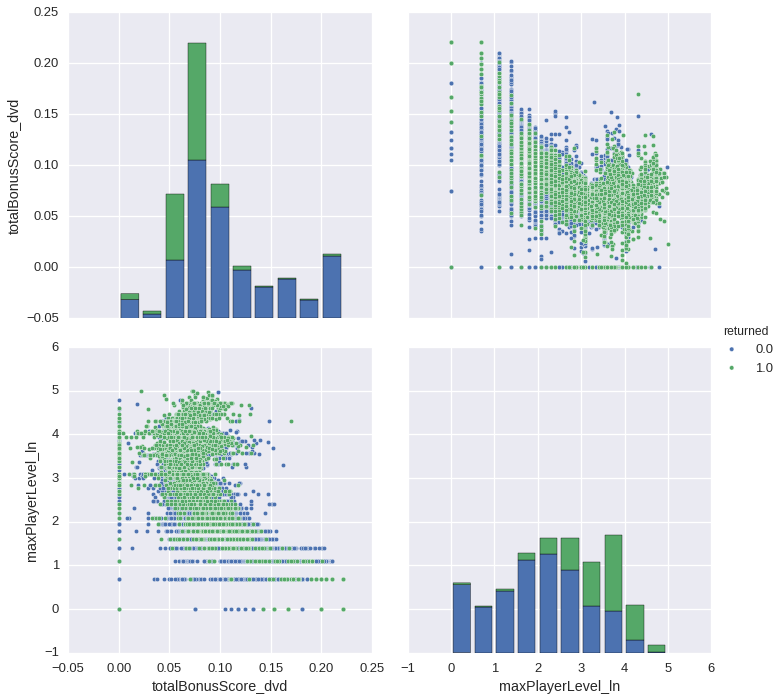

In [135]:
sns.pairplot(xytte, vars=["totalBonusScore_dvd", "maxPlayerLevel_ln"], 
             hue="returned", size=5)

attemptsOnTheHighestLevel_dvd            -0.530786
totalBonusScore_dvd                      -0.422223
allAttemptsOnTheHighestLevel             -0.341837
zeroTurnsPerCompletedLevel               -0.146913
zeroTotalScore                           -0.146866
attLevelsMoreThanMaxLevel                 0.119402
numberOfAttemptedLevels_dvd               0.202083
doReturnOnLowerLevels                     0.280431
attemptsOnTheHighestLevel                 0.281604
totalScore_ln_dvd                         0.332167
fractionOfUsefullBoosters                 0.357711
averageNumOfTurnsPerCompletedLevel_dvd    0.395277
attemptsOnTheHighestLevel_ln              0.419335
returned                                  0.456199
averageNumOfTurnsPerCompletedLevel        0.513083
totalScore_ln                             0.541047
maxPlayerLevel                            0.581844
numberOfBoostersUsed_dvd                  0.618833
maxPlayerLevel_ln                         0.619232
numberOfBoostersUsed_dvd_ln    

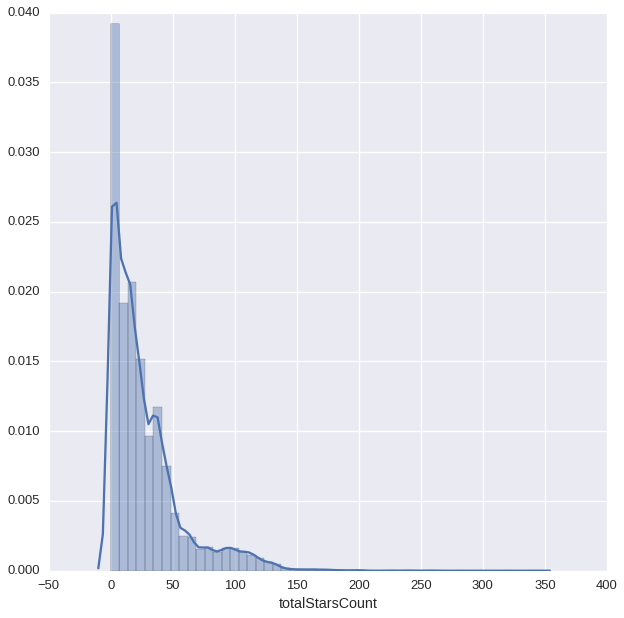

In [136]:
# мне все нравится
# totalStarsCount

sns.distplot(xytte.totalStarsCount)
xytte.corrwith(xytte.totalStarsCount).sort_values()

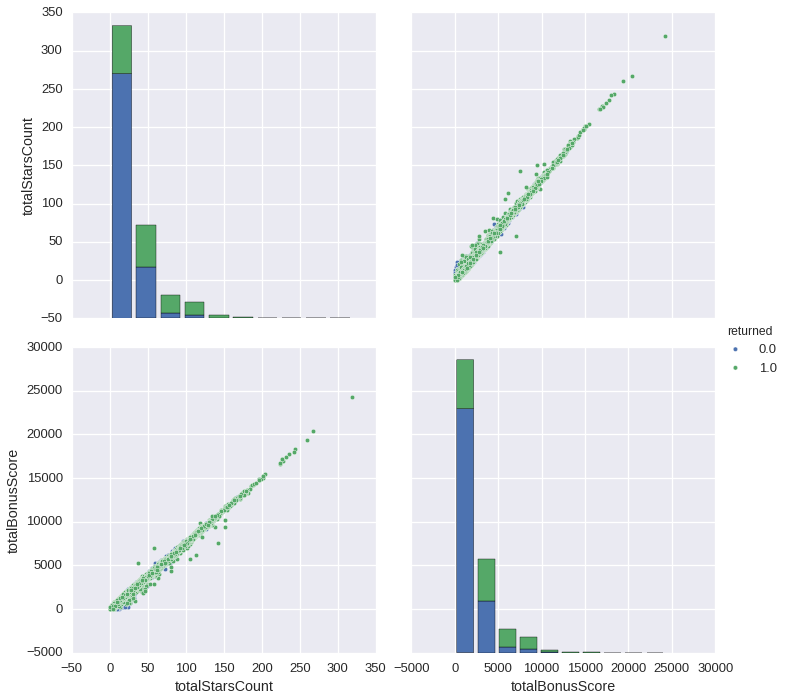

In [137]:
# корреляция в 0.99 говорит, что ты пидор
# а точнее, что звезды даются за бонус скор
# ничего интересного мы не получим, даже если разделим, но попытаться можно

sns.pairplot(xytte, vars=["totalStarsCount", "totalBonusScore"], hue="returned", size=5)

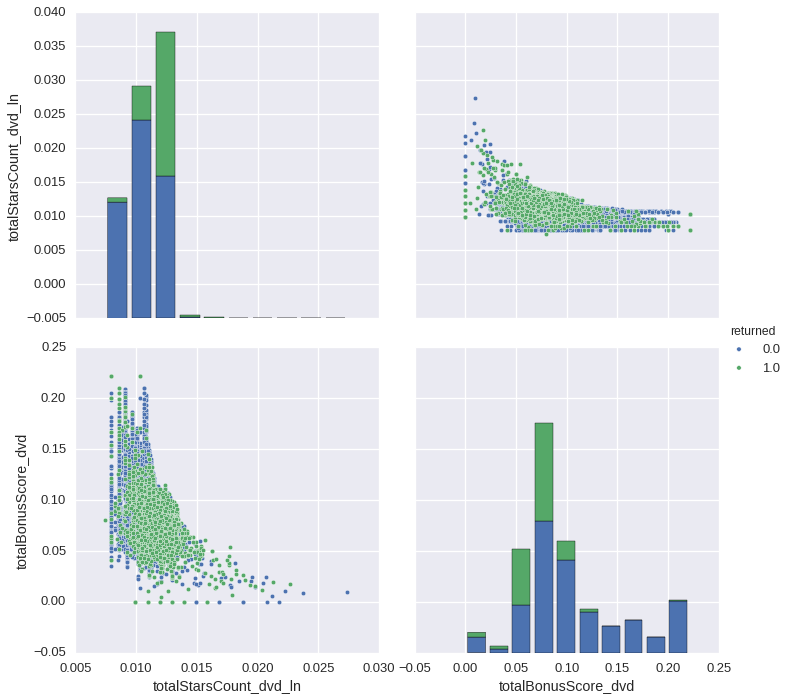

In [140]:
# так и не удалось избавиться от страшной корреляции, ну пусть остается, хули

xytte["totalStarsCount_dvd"] = (xytte["totalStarsCount"] + 10) / (xytte["totalBonusScore"] + 1000)
xytte["totalStarsCount_ln"] = xytte["totalStarsCount"].apply(lambda x: np.log(x+1))
xytte["totalStarsCount_dvd_ln"] = xytte["totalStarsCount_dvd"].apply(lambda x: np.log(x+1))

sns.pairplot(xytte, vars=["totalStarsCount_dvd_ln", "totalBonusScore_dvd"], hue="returned", size=5)

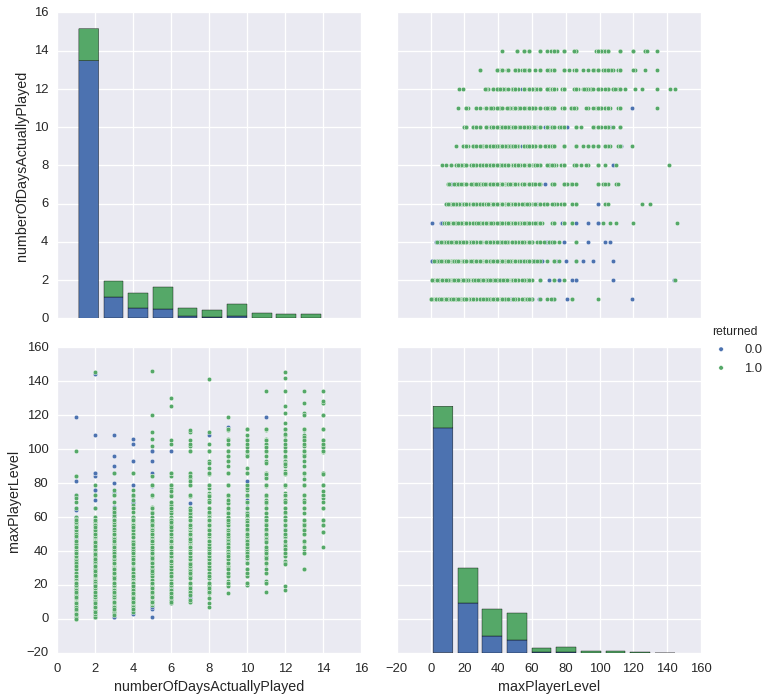

In [141]:
# последняя хуерга
# numberOfDaysActuallyPlayed

sns.pairplot(xytte, vars=["numberOfDaysActuallyPlayed", "maxPlayerLevel"], hue="returned", size=5)

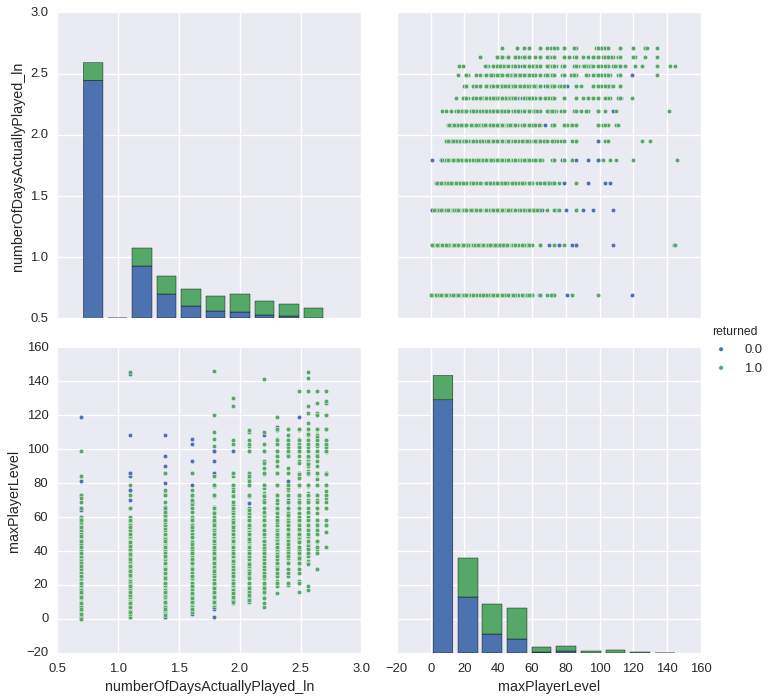

In [142]:
# логарифм

xytte["numberOfDaysActuallyPlayed_ln"] = xytte["numberOfDaysActuallyPlayed"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["numberOfDaysActuallyPlayed_ln", "maxPlayerLevel"], hue="returned", size=5)

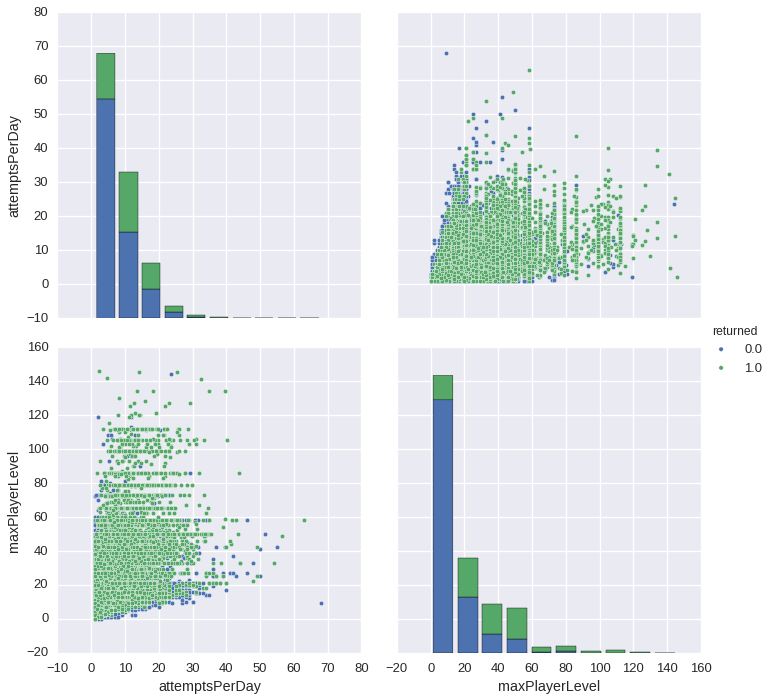

In [143]:
# высокую корреляцию показывает с totalNumOfAttempts
# возможно, стоит ввести attemptsPerDay

xytte["attemptsPerDay"] = xytte["totalNumOfAttempts"] / xytte["numberOfDaysActuallyPlayed"]
sns.pairplot(xytte, vars=["attemptsPerDay", "maxPlayerLevel"], hue="returned", size=5)

In [157]:
all_params = list(xytte.columns)
all_params

['maxPlayerLevel',
 'numberOfAttemptedLevels',
 'attemptsOnTheHighestLevel',
 'totalNumOfAttempts',
 'averageNumOfTurnsPerCompletedLevel',
 'doReturnOnLowerLevels',
 'numberOfBoostersUsed',
 'fractionOfUsefullBoosters',
 'totalScore',
 'totalBonusScore',
 'totalStarsCount',
 'numberOfDaysActuallyPlayed',
 'returned',
 'maxPlayerLevel_ln',
 'numberOfAttemptedLevels_dvd',
 'attLevelsMoreThanMaxLevel',
 'attemptsOnTheHighestLevel_ln',
 'totalNumOfAttempts_ln',
 'attemptsOnTheHighestLevel_dvd',
 'allAttemptsOnTheHighestLevel',
 'zeroTurnsPerCompletedLevel',
 'averageNumOfTurnsPerCompletedLevel_dvd',
 'numberOfBoostersUsed_ln',
 'numberOfBoostersUsed_dvd',
 'numberOfBoostersUsed_dvd_ln',
 'totalScore_ln',
 'totalScore_ln_dvd',
 'zeroTotalScore',
 'totalBonusScore_dvd',
 'totalStarsCount_dvd',
 'totalStarsCount_ln',
 'totalStarsCount_dvd_ln',
 'numberOfDaysActuallyPlayed_ln',
 'attemptsPerDay',
 'maxPlayerLevel_norm',
 'numberOfAttemptedLevels_norm',
 'attemptsOnTheHighestLevel_norm',
 'tota

In [148]:
# отдельно закинем булевы, которые не надо нормализовывать
bool_params = [
    'doReturnOnLowerLevels',
    'returned',
    'attLevelsMoreThanMaxLevel',
    'allAttemptsOnTheHighestLevel',
    'zeroTurnsPerCompletedLevel',
    'zeroTotalScore'
]

In [151]:
# нормализуем все остальные
# сначала херанем функцию norm, которая нормализует датафрейм или колонку
norm = lambda x: (x - x.mean())/x.std()

for item in [item for item in all_params if item not in bool_params]:
    xytte[item + "_norm"] = (xytte[item] - xytte[item].mean()) / xytte[item].std()

In [154]:
len(list(xytte.columns))

62

In [156]:
xytte.to_csv("data/xytte.csv", index=False)